Карпеченко Д.М., dz20, v.0.1, 04.01.2023

In [1]:
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [2]:
data = pd.read_csv(r'D:\TeachMeSkills\DZ\dz20\accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
plotly_df(data, title = "Accidental deaths in USA: monthly, 1973 - 1978")

In [207]:
data.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'Death'}, inplace=True)

In [208]:
data.describe()

,Death
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


Из графика видим, что наибольшее количество сметрей выпадает на июль месяц, а наименьшее - на февраль. Интересная ситуация с декабрем, т.к. до 1976 года тенденция на уменьшение количества смертей меняется на противоположную.

Несмотря на то, что из данных и так видны какие то тенденции изменений построим двойное экспоненциальное сглаживание с параметрами альфа и бета 0,5, 0,6

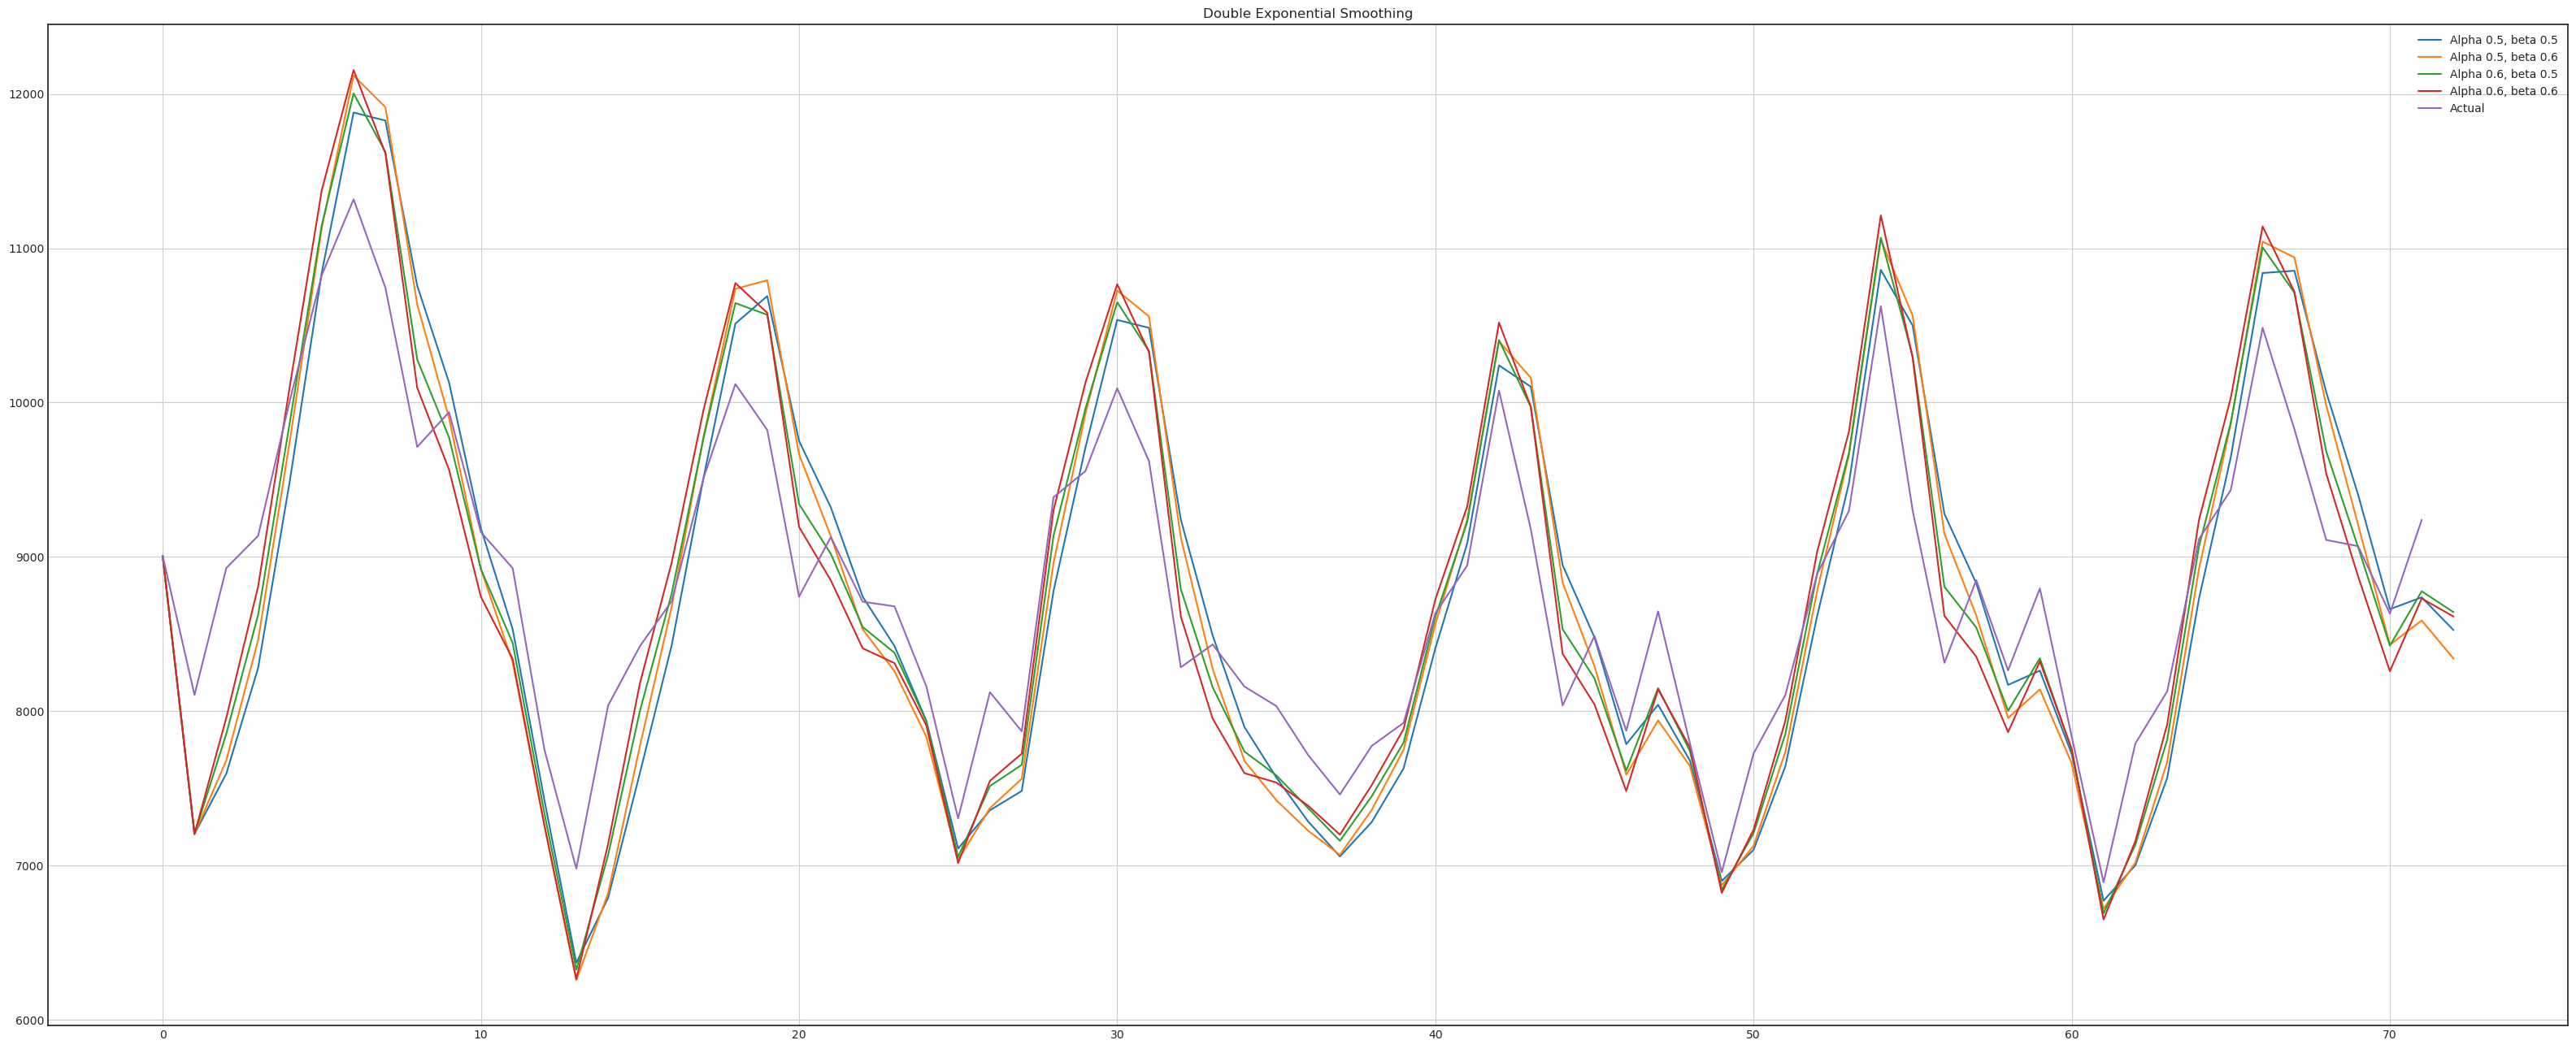

In [209]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(40, 16))
    for alpha in [0.5, 0.6]:
        for beta in [0.5, 0.6]:
            plt.plot(double_exponential_smoothing(data.Death, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data.Death.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [210]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        #Расширенный тест единичного корня Дики-Фуллера.
        #Расширенный тест Дики-Фуллера можно использовать для проверки единичного корня в одномерном процессе при наличии последовательной корреляции.


        plt.tight_layout()
    return 

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.102481


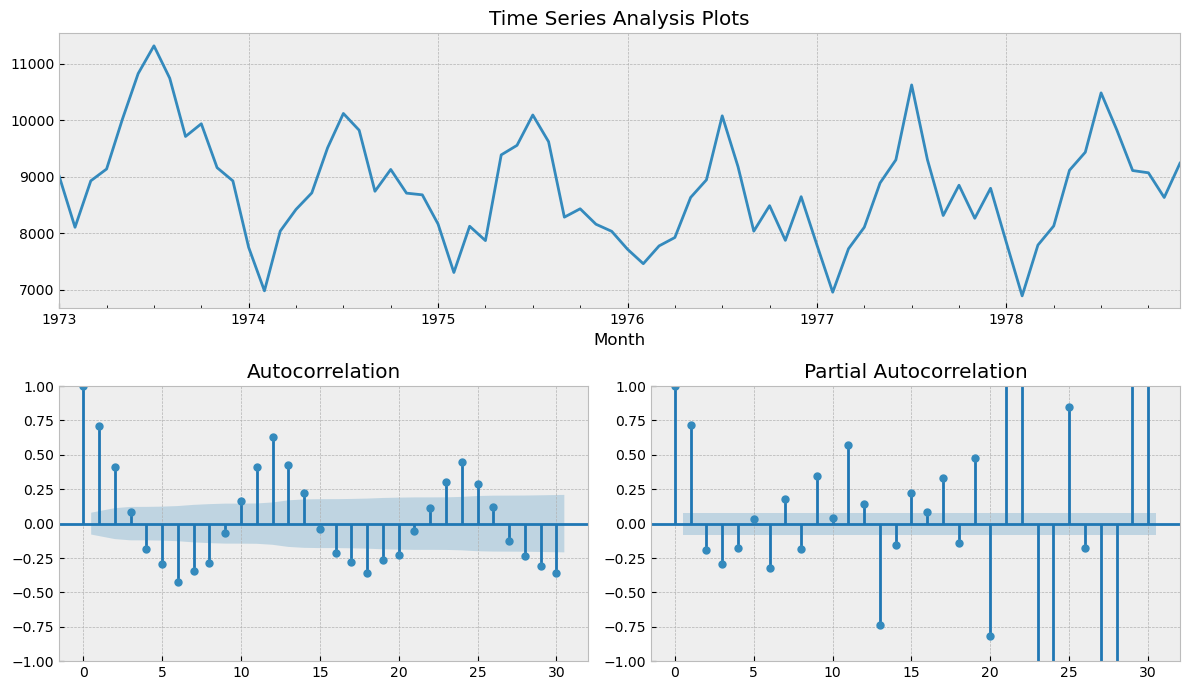

In [211]:
tsplot(data.Death, lags=30)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.086943
Оптимальный параметр преобразования Бокса-Кокса: -0.275376


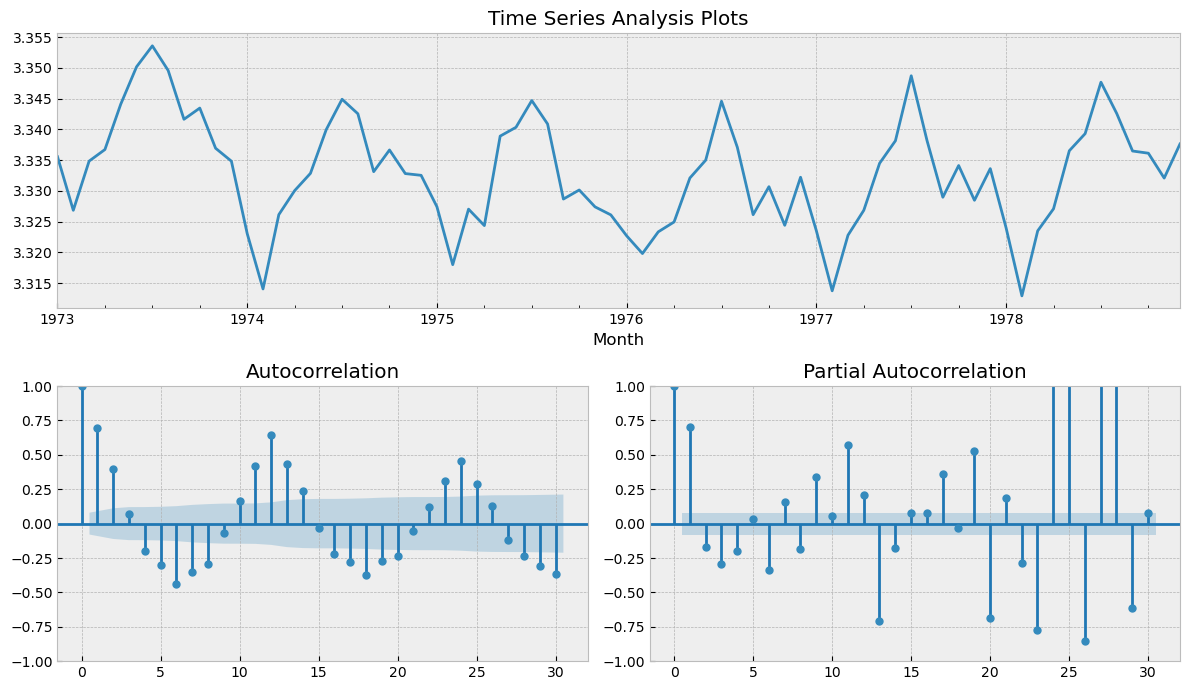

In [212]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data1 = data.copy()
data1['Death_box'], lmbda = scs.boxcox(data1.Death)
tsplot(data1.Death_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.005633


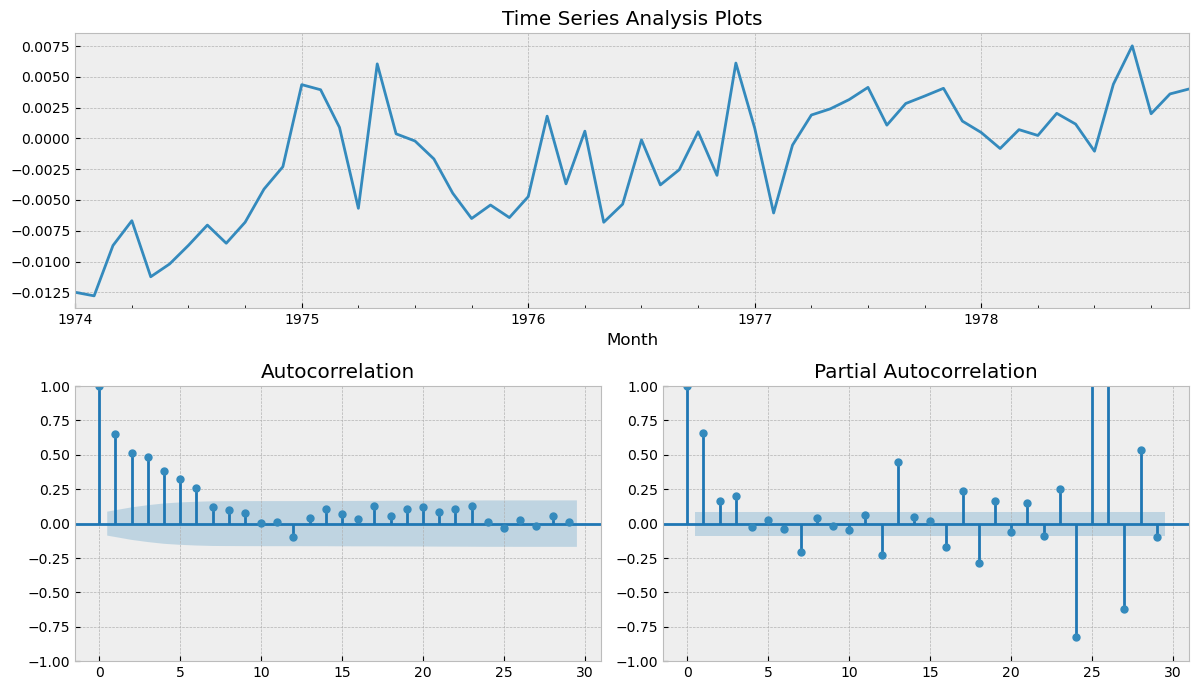

In [213]:
data1['Death_box_season'] = data1.Death_box - data1.Death_box.shift(1*12)
tsplot(data1.Death_box_season[1*12:], lags=29)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.000117


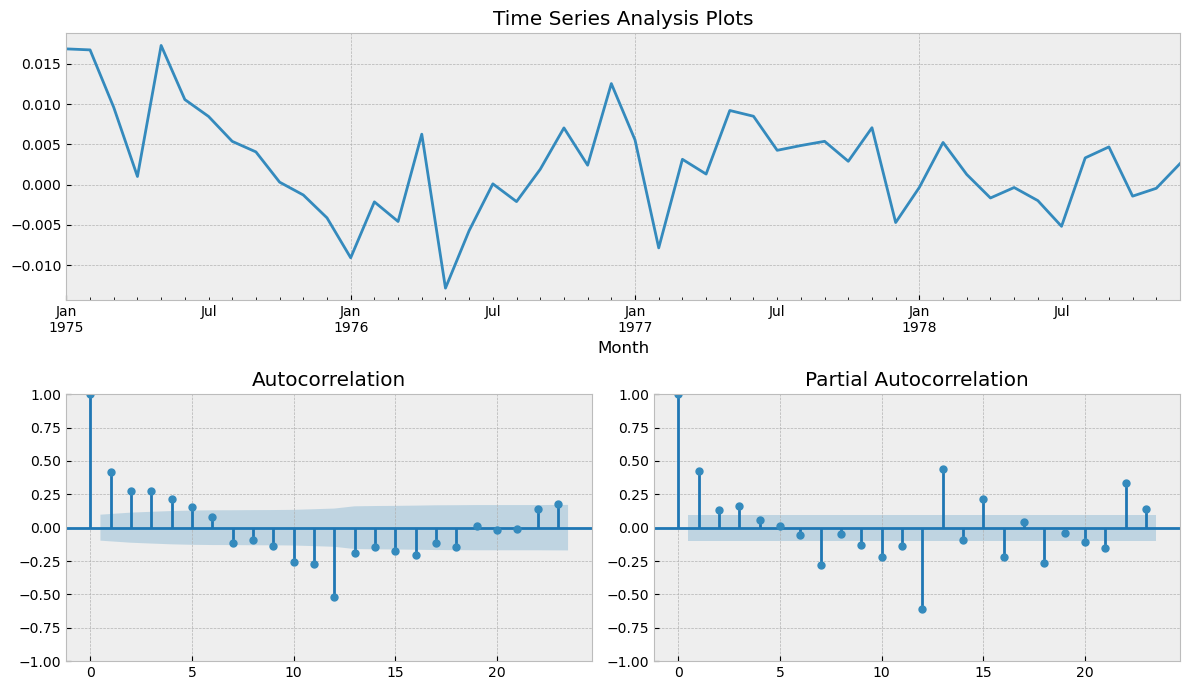

In [214]:
data1['Death_box_season_diff'] = data1.Death_box_season - data1.Death_box_season.shift(1*12)
tsplot(data1.Death_box_season_diff[1*12+12:], lags=23)

# SARIMAX

In [215]:
best_model=sm.tsa.statespace.SARIMAX(data1.Death_box, order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12)).fit(disp=-1)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\HP\anaconda3\envs\My\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [216]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Death_box   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 256.154
Date:                            Mon, 02 Jan 2023   AIC                           -502.308
Time:                                    17:12:02   BIC                           -491.921
Sample:                                01-01-1973   HQIC                          -498.253
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1193      0.238      0.501      0.616      -0.347       0.586
ma.L1         -0.6216      0.205   

C:\Users\HP\anaconda3\envs\My\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log

C:\Users\HP\AppData\Local\Temp\ipykernel_24628\3563949799.py:3: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



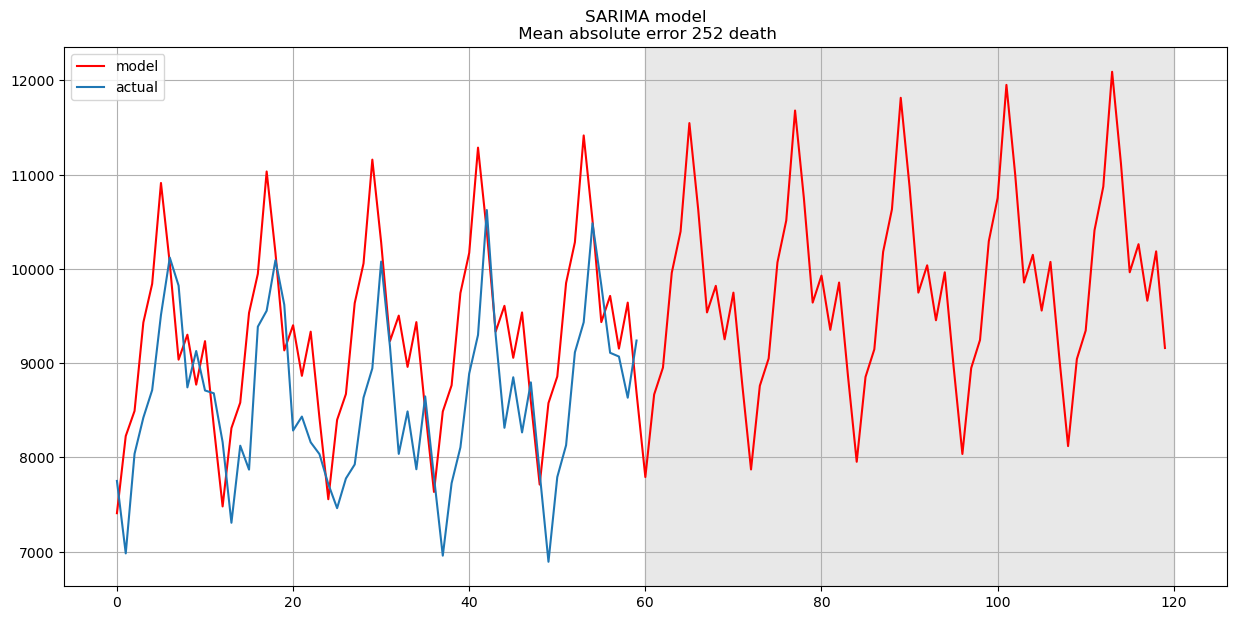

In [217]:
data1["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data1.shape[0], end = data1.shape[0]+120), lmbda)
forecast = data1.arima_model.append(forecast).values[-120:]
actual = data1.Death.values[-60:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} death".format(round(mean_absolute_error(data1.dropna().Death, data1.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# LinearRegression

In [243]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [269]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [271]:
X_train, X_test, y_train, y_test = prepareData(data.Death, test_size=0.3, lag_start=5, lag_end=6)

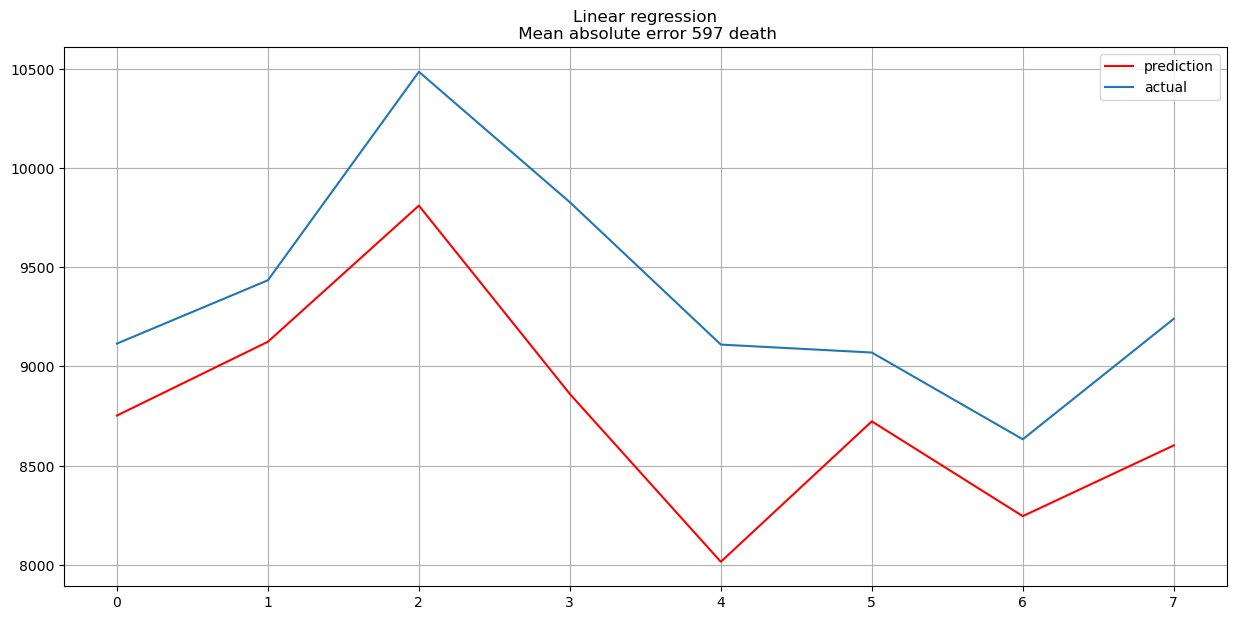

In [291]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data.Death, test_size=0.3, lag_start=12, lag_end=15)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} death".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [292]:
mean_squared_error(y_test,lr.predict(X_test))**0.5

660.2919392163511

# Prophet

In [293]:
from prophet import Prophet

In [304]:
data=data.reset_index()
data=data.rename(columns={"Month": "ds", "Death": "y"})

In [305]:
train = data[:-3*12]

test = data[-3*12:]

In [306]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\HP\anaconda3\envs\My\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [315]:
future = m.make_future_dataframe(periods=48, freq='M')
future.tail()

,ds
79,1979-07-31
80,1979-08-31
81,1979-09-30
82,1979-10-31
83,1979-11-30


In [316]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

C:\Users\HP\anaconda3\envs\My\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\HP\anaconda3\envs\My\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
79,1979-07-31,6249.416655,4151.068591,8161.043370
80,1979-08-31,4294.260837,2125.622064,6267.658091
81,1979-09-30,4170.937191,1875.166548,6208.599942
82,1979-10-31,4564.335623,2238.155849,6647.680786
83,1979-11-30,4250.672857,1836.983456,6355.369778


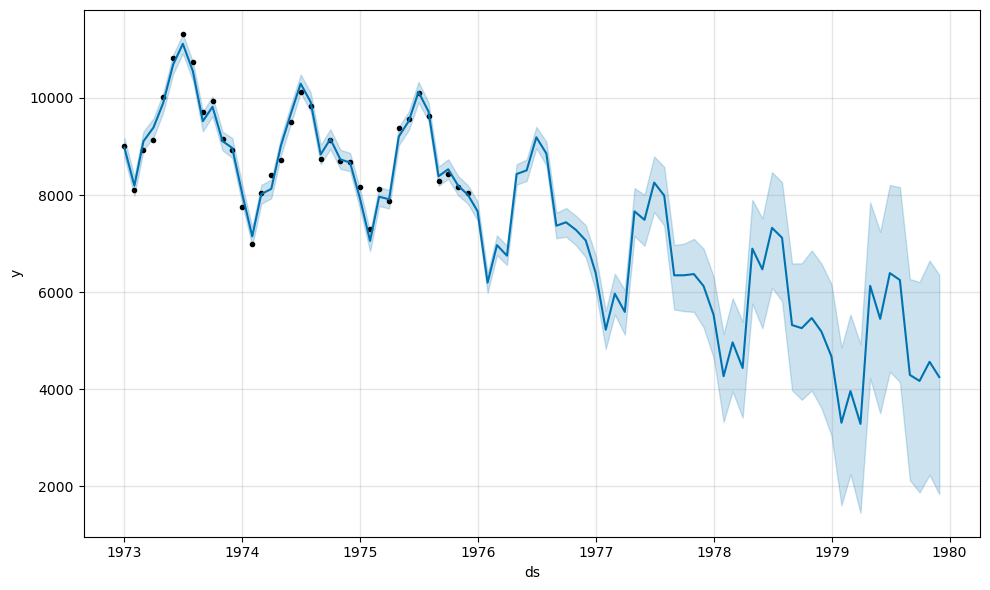

In [317]:
fig1 = m.plot(forecast)

C:\Users\HP\anaconda3\envs\My\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



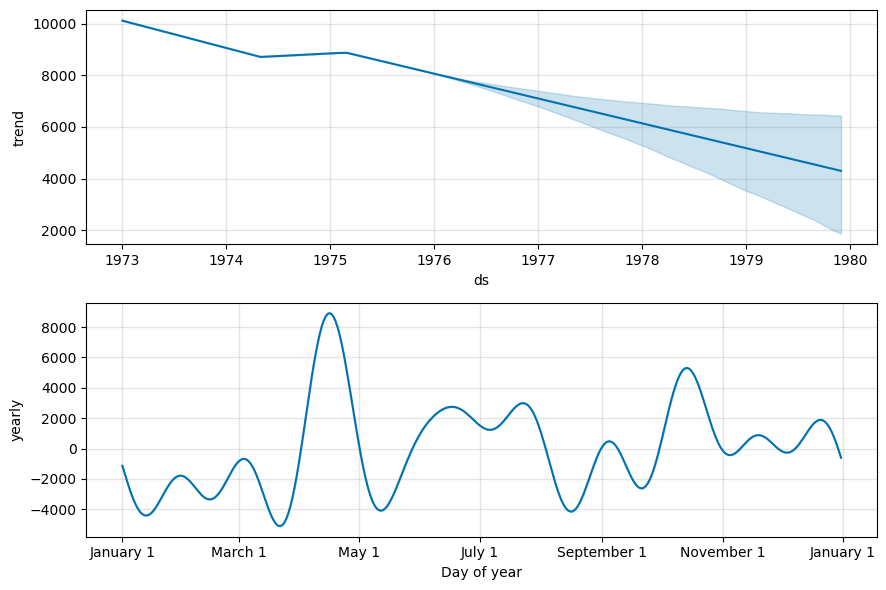

In [318]:
fig2 = m.plot_components(forecast)

In [319]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1973-01-01,10110.665792,8787.646732,9170.609702,10110.665792,10110.665792,-1136.515583,-1136.515583,-1136.515583,-1136.515583,-1136.515583,-1136.515583,0.0,0.0,0.0,8974.150208
1,1973-02-01,10021.097108,7985.959259,8379.451052,10021.097108,10021.097108,-1829.295043,-1829.295043,-1829.295043,-1829.295043,-1829.295043,-1829.295043,0.0,0.0,0.0,8191.802064
2,1973-03-01,9940.196359,8920.640885,9308.033496,9940.196359,9940.196359,-834.131166,-834.131166,-834.131166,-834.131166,-834.131166,-834.131166,0.0,0.0,0.0,9106.065194
3,1973-04-01,9850.627673,9182.764014,9575.802759,9850.627673,9850.627673,-460.902445,-460.902445,-460.902445,-460.902445,-460.902445,-460.902445,0.0,0.0,0.0,9389.725228
4,1973-05-01,9763.948300,9696.605203,10090.448564,9763.948300,9763.948300,128.406370,128.406370,128.406370,128.406370,128.406370,128.406370,0.0,0.0,0.0,9892.354669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1979-07-31,4618.183235,4151.068591,8161.043370,2529.551342,6486.633073,1631.233420,1631.233420,1631.233420,1631.233420,1631.233420,1631.233420,0.0,0.0,0.0,6249.416655
80,1979-08-31,4536.566113,2125.622064,6267.658091,2384.020274,6478.365436,-242.305276,-242.305276,-242.305276,-242.305276,-242.305276,-242.305276,0.0,0.0,0.0,4294.260837
81,1979-09-30,4457.581801,1875.166548,6208.599942,2195.211213,6475.806090,-286.644610,-286.644610,-286.644610,-286.644610,-286.644610,-286.644610,0.0,0.0,0.0,4170.937191
82,1979-10-31,4375.964679,2238.155849,6647.680786,2003.864987,6444.735117,188.370944,188.370944,188.370944,188.370944,188.370944,188.370944,0.0,0.0,0.0,4564.335623


In [323]:
print(mean_squared_error(np.array(test['y']),forecast['yhat'][-36:])**0.5)

3104.7752299945932


In [324]:
print(mean_absolute_error(np.array(test['y']),forecast['yhat'][-36:]))

2902.953202926772


Выводы: линейная регрессия и sarima показали очень подозрительные результаты (слишком точные). Наши данные представляют стационарный ряд, поэтому для приведения его в стационарный нужно потрать слишком много сил и времени). Prophet показала себя неплохо, не нужно мучится с параметрами и сразу дает более приземленный прогноз.